# Grupo Bimbo Inventory Demand

Notebook con la implementación del modelo para [esta](https://www.kaggle.com/c/grupo-bimbo-inventory-demand) competencia en kaggle.


### Ideas principales

* Ocupar redes neuronales con la librería tensorflow.
* Ocupar procesos guassianos con librería por seleccionar.

### Archivos

* train.csv — the training set
* test.csv — the test set
* sample_submission.csv — a sample submission file in the correct format
* cliente_tabla.csv — client names (can be joined with train/test on Cliente_ID)
* producto_tabla.csv — product names (can be joined with train/test on Producto_ID)
* town_state.csv — town and state (can be joined with train/test on Agencia_ID)


### Features

* Semana — Week number (From Thursday to Wednesday)
* Agencia_ID — Sales Depot ID
* Canal_ID — Sales Channel ID
* Ruta_SAK — Route ID (Several routes = Sales Depot)
* Cliente_ID — Client ID
* NombreCliente — Client name
* Producto_ID — Product ID
* NombreProducto — Product Name
* Venta_uni_hoy — Sales unit this week (integer)
* Venta_hoy — Sales this week (unit: pesos)
* Dev_uni_proxima — Returns unit next week (integer)
* Dev_proxima — Returns next week (unit: pesos)
* Demanda_uni_equil — Adjusted Demand (integer) (This is the target you will predict)

# Análisis de los datos

Primero importamos las librerías necesarias

In [1]:
%matplotlib inline
import numpy as np
import tensorflow as tf
import csv
import matplotlib.pyplot as plt
import time
import pandas as pd

Generamos una función para leer los datos. Retorna un dataFrame (pandas) de los datos.

In [2]:
# fileName: Name of the csv file.
# Columns: Array with the strings of each column in order.
# rows: Number of rows to be read. None = All.
def readData(fileName, columns, rows=None):
    print('Reading file:', fileName)
    start = time.time()
    ret = pd.read_csv(fileName, usecols=columns, nrows=rows)
    finish = time.time()
    print('Shape:', str(ret.shape))
    print('Execution time (seconds):', str(finish-start))
    return ret

**NOTA:** Importar una columna completa del archivo train demora aproximadamente 1 minuto.

In [3]:
# How many rows we'll load
total_loaded = 1000000

# Import the dataset
columns = ['Semana', 'Agencia_ID', 'Canal_ID', 'Ruta_SAK', 'Cliente_ID', 'Producto_ID', 'Demanda_uni_equil']
dataset = readData('Archivos/train.csv', columns, rows=total_loaded)

Reading file: Archivos/train.csv
Shape: (1000000, 7)
Execution time (seconds): 0.7414398193359375


Inspeccionemos los datos primero antes de generar cualquier modelo.  
Nuestro valor objetivo es la última columna de nuestros datos: *Demanda_uni_equil*, veamos como se distribuye sobre los datos que hemos tomado.

In [4]:
# Recieves an array of elements and plot its histogram
# array: Values
# maxValue: Max value to be shown in the histogram
def toHist(array, maxValue, title='', xlabel='', ylabel=''):
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.hist(array[array<maxValue], bins=200, color='blue')
    plt.show()

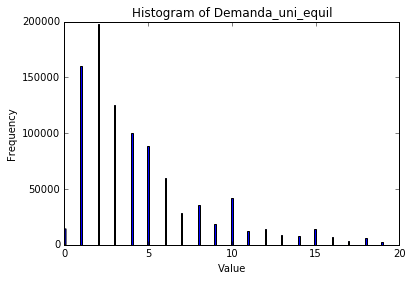

In [5]:
demanda_uni_equil = dataset['Demanda_uni_equil']
toHist(demanda_uni_equil, 20, 'Histogram of Demanda_uni_equil', 'Value', 'Frequency')

Función para poder agrupar los valores de un dataFrame de acuerdo a los valores de cierta columna. Nos retorna una tupla con todos los valores distintos de la columna y un diccionario donde la llave es el valor y retorna un dataFrame con todas las filas con ese valor en la columna específica.

In [6]:
# Recieves a dataFrame and a column name (string) and returns a tuple 
# with the keys and a dict
# where the key is de column value and the value is a dataFrame with all
# the rows that have that column value.
def groupBy(dataFrame, columnName):
    different_values = dataFrame[columnName].drop_duplicates()
    dictionary = dict()
    for value in different_values:
        # Select the data that have value in the columnName field.
        data = dataFrame.loc[dataFrame[columnName]==value]
        dictionary[value] = data
    return (different_values, dictionary)

La función anterior se usaba, ya no.

# Modelamiento con NN

A priori, haremos que la red reciba como input las 7 características que entrega el archivo test. Ocuparemos la función de error del programa.

In [12]:
# The data is divided (seudo)randomnly in 3 groups: train_dataset, valid_dataset, and test_dataset.

train_size = 30000
valid_size = 10000
test_size = 10000

#-------------------------------------------------------
# TODO: Hacer que las características que no tienen un orden (todas menos semana) sean one hot encoding.
#-------------------------------------------------------

# 6 feautres + output
train = dataset.sample(train_size)
valid = dataset.sample(valid_size)
test = dataset.sample(test_size)

# 6 features only, now they are numpy arrays
train_dataset = train.drop('Demanda_uni_equil', axis=1).as_matrix().astype('float32')
valid_dataset = valid.drop('Demanda_uni_equil', axis=1).as_matrix()
test_dataset = test.drop('Demanda_uni_equil', axis=1).as_matrix()

# Outputs
train_output = train['Demanda_uni_equil'].as_matrix()
valid_output = valid['Demanda_uni_equil'].as_matrix()
test_output = test['Demanda_uni_equil'].as_matrix()

print('Train dataset', train_dataset.shape)
print('      outputs', train_output.shape)
print('Valid dataset', valid_dataset.shape)
print('      outputs', valid_output.shape)
print('Test  dataset', test_dataset.shape)
print('      outputs', test_output.shape)

Train dataset (30000, 6)
      outputs (30000,)
Valid dataset (10000, 6)
      outputs (10000,)
Test  dataset (10000, 6)
      outputs (10000,)


In [14]:
# Model deep neural network with stochastic gradient descent for speed.

# How many features we want to use
features = 6
# Size of the placeholder in the train input data.
batch_size = 512
hidden_nodes = 1024
beta = 0.001

graph = tf.Graph()

with graph.as_default():
    
    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, features))
    # We only have one output, the prediction.
    tf_train_outputs = tf.placeholder(tf.float32, shape=(batch_size, 1))
    # The valid dataset and the test dataset remain as constants.
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    #------------
    # Variables:
    #------------
    
    # First layer
    weights1 = tf.Variable(
        tf.truncated_normal([features, hidden_nodes]))
    biases1 = tf.Variable(tf.zeros([hidden_nodes]))
    
    # Hidden layer
    weights2 = tf.Variable(
        tf.truncated_normal([hidden_nodes, 1]))
    biases2 = tf.Variable(tf.zeros([1]))
    
    #----------------------
    # Training computation.
    #----------------------
    
    # Outputs after the first layer:
    # We are using RELU, thats the non linearity in our model
    outputs1 = tf.nn.relu( tf.matmul(tf_train_dataset, weights1) + biases1 )
    
    # Output after the second layer:
    output = tf.matmul(outputs1, weights2) + biases2
    
    #-------
    # Loss
    #-------
    loss = tf.sqrt( tf.reduce_mean( tf.square(tf.log(output+1) - tf.log(tf_train_outputs+1)) )) #+beta*tf.l2_loss(weights1) + tf.nn.l2_loss(weights2)
    
    #-----------
    # Optimizer
    #-----------
  
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(output)
    valid_prediction = tf.nn.softmax( tf.matmul(
        tf.nn.relu( tf.matmul(tf_valid_dataset, weights1) + biases1 ) , weights2)
                                     + biases2)
    test_prediction = tf.nn.softmax( tf.matmul(
        tf.nn.relu( tf.matmul(tf_test_dataset, weights1) + biases1 ) , weights2) + biases2)

TypeError: DataType int64 for attr 'T' not in list of allowed values: float32, float64, int32, complex64